### 零、分析框架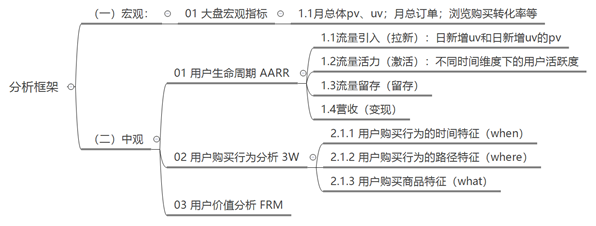

In [2]:
import numpy as np
import pandas as pd
import pyecharts
from datetime import datetime
from datetime import timedelta

In [3]:
data = pd.read_csv(r"F:\data analysis report\02.2014taobao\tianchi_mobile_recommend_train_user.csv")
data.head()

,user_id,item_id,behavior_type,user_geohash,item_category,time
0,98047837,232431562,1,NaN,4245,2014-12-06 02
1,97726136,383583590,1,NaN,5894,2014-12-09 20
2,98607707,64749712,1,NaN,2883,2014-12-18 11
3,98662432,320593836,1,96nn52n,6562,2014-12-06 10
4,98145908,290208520,1,NaN,13926,2014-12-16 21


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12256906 entries, 0 to 12256905
Data columns (total 6 columns):
user_id          int64
item_id          int64
behavior_type    int64
user_geohash     object
item_category    int64
time             object
dtypes: int64(4), object(2)
memory usage: 561.1+ MB


### 一、数据清洗

1.缺失值处理

In [5]:
data.isnull().sum()

user_id                0
item_id                0
behavior_type          0
user_geohash     8334824
item_category          0
time                   0
dtype: int64

2.异常值处理

In [6]:
data.describe()

,user_id,item_id,behavior_type,item_category
count,1.225691e+07,1.225691e+07,1.225691e+07,1.225691e+07
mean,7.170732e+07,2.023084e+08,1.105271e+00,6.846162e+03
std,4.122920e+07,1.167397e+08,4.572662e-01,3.809922e+03
min,4.913000e+03,6.400000e+01,1.000000e+00,2.000000e+00
25%,3.584965e+07,1.014130e+08,1.000000e+00,3.721000e+03
50%,7.292804e+07,2.021359e+08,1.000000e+00,6.209000e+03
75%,1.073774e+08,3.035405e+08,1.000000e+00,1.029000e+04
max,1.424559e+08,4.045625e+08,4.000000e+00,1.408000e+04


In [7]:
'''当输入include=['O']，会计算离散型变量的统计特征'''
data.describe(include=['O'])

,user_geohash,time
count,3922082,12256906
unique,575458,744
top,94ek6ke,2014-12-11 22
freq,1052,54797


3.去重


对data去重，发现有多行完全重复，但基于时间column单位是小时：
同一用户可以在一小时内对商品多次收藏多次取消，甚至多次购买，故不去重

In [8]:
# data=data.drop_duplicates()

4.一致化处理

（1）将时间拆分为日期，小时以及其对应的星期

In [9]:
data['date'] = data['time'].apply(lambda x:x.split(' ')[0])
data['hour'] = data['time'].apply(lambda x:x.split(' ')[1])

（2）将time、date调整为datetime，hour调整为int64

In [10]:
data['time']=pd.to_datetime(data['time'])
data['date']=pd.to_datetime(data['date'])
data['hour']=data['hour'].astype('int64')

（3）将日期转化为对应的星期

In [11]:
data['week']=data['date'].dt.weekday
data['week'].unique()

array([5, 1, 3, 2, 4, 0, 6], dtype=int64)

查找日历后，{0:星期一...6:星期天}，week+1得到正确的北京时间

In [12]:
data['week']=data['week'].apply(lambda s:s+1)

（4）将behavior_type调整为对应的行为，{1:pv...4:buy}

In [13]:
data.loc[data['behavior_type']==1,'behavior_type']='pv'
data.loc[data['behavior_type']==2,'behavior_type']='fav'
data.loc[data['behavior_type']==3,'behavior_type']='cart'
data.loc[data['behavior_type']==4,'behavior_type']='buy'

（5）确认时间在给定范围内

In [14]:
data[(data['date']>'2014-12-18') | (data['date']<'2014-11-18')]

,user_id,item_id,behavior_type,user_geohash,item_category,time,date,hour,week


数据的分布

In [15]:
data.describe()

,user_id,item_id,item_category,hour,week
count,1.225691e+07,1.225691e+07,1.225691e+07,1.225691e+07,1.225691e+07
mean,7.170732e+07,2.023084e+08,6.846162e+03,1.481799e+01,3.922520e+00
std,4.122920e+07,1.167397e+08,3.809922e+03,6.474778e+00,1.931473e+00
min,4.913000e+03,6.400000e+01,2.000000e+00,0.000000e+00,1.000000e+00
25%,3.584965e+07,1.014130e+08,3.721000e+03,1.000000e+01,2.000000e+00
50%,7.292804e+07,2.021359e+08,6.209000e+03,1.600000e+01,4.000000e+00
75%,1.073774e+08,3.035405e+08,1.029000e+04,2.000000e+01,6.000000e+00
max,1.424559e+08,4.045625e+08,1.408000e+04,2.300000e+01,7.000000e+00


In [16]:
data.describe(include=['O'])

,behavior_type,user_geohash
count,12256906,3922082
unique,4,575458
top,pv,94ek6ke
freq,11550581,1052


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12256906 entries, 0 to 12256905
Data columns (total 9 columns):
user_id          int64
item_id          int64
behavior_type    object
user_geohash     object
item_category    int64
time             datetime64[ns]
date             datetime64[ns]
hour             int64
week             int64
dtypes: datetime64[ns](2), int64(5), object(2)
memory usage: 841.6+ MB


通过观察数据集无异常值存在。

### 二、数据分析

#### （一）宏观：

1.大盘宏观指标

In [22]:
# PV：总浏览页面数
total_pv = data["user_id"].count()
total_pv

12256906

In [23]:
# UV：独立访客数
total_uv = data["user_id"].nunique()
total_uv

10000

In [24]:
# OD：总订单数
data[data['behavior_type']=="buy"].behavior_type.count()

120205

#### （二）中观

1.用户生命周期 AARR

1.1流量引入（拉新）：日新增用户及其行为数

In [31]:
da_group=data.groupby(['user_id','date']).count().reset_index()
da_group_drop=da_group.drop_duplicates(subset=['user_id'],keep='first').sort_values('date')

new_user=da_group_drop.groupby('date')['user_id'].count().reset_index().rename(columns={'user_id':'n_user'})
new_pv=da_group_drop.groupby('date')['behavior_type'].sum().reset_index().rename(columns={'behavior_type':'n_pv'})

In [32]:
# 绘图
from pyecharts import Line,Bar,Overlap

attr = new_user.date

n_pv = new_pv.n_pv
n_user = new_user.n_user

bar = Bar('日新增uv和日新增uv的pv对比图',title_pos='center',title_text_size=25)
bar.add('日新增uv',attr,n_user,
        xaxis_label_textsize=17,yaxis_label_textsize=17,
        yaxis_max=8000, yaxis_formatter="人",
        is_label_show=True,label_pos='outside',label_text_size=17,
        is_legend_show = True,legend_top='bottom',legend_pos='center',legend_text_size=18)

line = Line()
line.add('日新增uv的pv',attr,n_pv,yaxis_formatter="次",
         xaxis_label_textsize=17,yaxis_label_textsize=17,
         is_legend_show = True,legend_top='bottom',legend_pos='center',legend_orient='horizontal',legend_text_size=18)

overlap=Overlap(width=1200,height=650)
overlap.add(bar)
overlap.add(line,is_add_yaxis=True, yaxis_index=1)
overlap.render('日新增uv和日新增uv的pv对比图.html')

在样本时间范围内，日新增用户和日新增用户的浏览量均呈现明显下降趋势。这是由于时间截取，部分老客被认为是新增用户导致的。    

排除该因素后，日新增用户数量保持在每10000人中有10-30人的区间范围中。回顾淘宝发展历程，这也应证了淘宝在2014年正从野蛮扩展（拉新）逐步走向精细化运营（变现）。

同时，在大盘浏览量突升的12月12日，大盘浏览量为691712次。而当日新增用户仅贡献了575次。这说明12月12日活动主要目的是促活促交易，而非拉新。


1.2流量活力（激活）：不同时间维度下的用户活跃度

1.2.1日期维度下的uv和pv

In [33]:
pv_daily=data.groupby('date')['user_id'].count().rename('pv').reset_index()
uv_daily=data.groupby('date')['user_id'].apply(lambda s:s.drop_duplicates().count()).rename('uv').reset_index()

In [34]:
# 绘图

from pyecharts import Line

line1=Line('日期维度下的PV和UV',width=1200,height=650,title_pos='center',title_text_size=25)
line1.add('页面的访问量(PV)',pv_daily.date,pv_daily.pv,
         xaxis_label_textsize=17,yaxis_label_textsize=17,yaxis_max=1000000,yaxis_formatter="次",
          mark_point=['max', 'min'],mark_point_symbolsize=80,
         is_legend_show = True,legend_top='bottom',legend_pos='center',legend_orient='horizontal',legend_text_size=18)


line2=Line(width=1200,height=650)
line2.add('页面的独立访客数(UV)',uv_daily.date,uv_daily.uv,
         xaxis_label_textsize=17,yaxis_label_textsize=17,yaxis_max=10000,yaxis_formatter="人",
          mark_point=['max', 'min'],mark_point_symbolsize=80,
         is_legend_show = True,legend_top='bottom',legend_pos='center',legend_orient='horizontal',legend_text_size=18)

overlap=Overlap(width=1200,height=650)
overlap.add(line1)
overlap.add(line2,is_add_yaxis=True,yaxis_index=1)
overlap.render('日期维度下的PV和UV.html')

In [35]:
line = Line('每位独立访客平均访问数(PV/UV)',width=1200,height=650,title_pos='center',title_text_size=25)

line.add('每位独立访客平均访问数(PV/UV)',uv_daily.date,np.around(pv_daily.pv/uv_daily.uv,1),
         xaxis_label_textsize=17,yaxis_label_textsize=17,yaxis_formatter="次",
         mark_point=['max', 'min'],mark_point_symbolsize=80,
         is_legend_show = True,legend_top='bottom',legend_pos='center',legend_orient='horizontal',legend_text_size=18)

line.render('日期维度下的uv平均pv.html')

在日期维度下，浏览量（PV）、访客数（UV）和每客浏览量（PV/UV）总体波动趋势大体相同，从8号开始逐步攀升，并在12号当天暴增到达顶峰。其中双十二当天的浏览量、访客数、每客浏览量分别为日常的1.8倍、1.22倍和1.5倍。这都说明双十二活动效果明显，吸引力大，后续的“双十二”的类似活动，可以加长预热期，进一步增强活动的吸引力。

双十二当天访客数较日常增长近1500人，说明一些不活跃的用户也被激活，针对此类现象，可结合其他数据重点研究活动的哪种属性刺激了非活跃用户在双十二这天的用户行为，例如优惠，玩法等。

1.2.2星期维度下的uv和pv

In [36]:
data_week=data[(data.date<pd.to_datetime('2014-12-9'))]

pv_week=data_week.groupby('week')['user_id'].count().rename('pv').reset_index()
uv_week=data_week.drop_duplicates(['date','user_id']).groupby('week')['user_id'].count().rename('uv').reset_index()

In [37]:
# 绘图

from pyecharts import Line

line1=Line('星期维度下的PV和UV',width=1200,height=650,title_pos='center',title_text_size=25)
line1.add('页面的访问量(PV)',pv_week.week,np.around(pv_week.pv/3,0),
         xaxis_label_textsize=17,yaxis_label_textsize=17,yaxis_formatter="次",yaxis_max=700000,
          mark_point=['max', 'min'],mark_point_symbolsize=80,
         is_legend_show = True,legend_top='bottom',legend_pos='center',legend_orient='horizontal',legend_text_size=18)

line2=Line(width=1200,height=650)
line2.add('页面的独立访客数(UV)',uv_week.week,np.around(uv_week.uv/3,0),
         xaxis_label_textsize=17,yaxis_label_textsize=17,yaxis_formatter="人",
          mark_point=['max', 'min'],mark_point_symbolsize=80,
         is_legend_show = True,legend_top='bottom',legend_pos='center',legend_orient='horizontal',legend_text_size=18)

overlap=Overlap(width=1200,height=650)
overlap.add(line1)
overlap.add(line2,is_add_yaxis=True,yaxis_index=1)
overlap.render('星期维度下的PV和UV.html')

In [38]:
line = Line('每位独立访客平均访问数(PV/UV)',
            width=1200,height=650,title_pos='center',title_text_size=25)

line.add('每位独立访客平均访问数(PV/UV)',uv_week.week,np.around(pv_week.pv/uv_week.uv,1),
         xaxis_label_textsize=17,yaxis_label_textsize=17,yaxis_formatter="次",
         mark_point=['max', 'min'],mark_point_symbolsize=80,
         is_legend_show = True,legend_top='bottom',legend_pos='center',legend_orient='horizontal',legend_text_size=18)

line.render('星期维度下的uv平均pv.html')

在星期维度下，浏览量（PV）、访客数（UV）和每客浏览量（PV/UV）总体波动趋势大体相同，且整体都相对稳定。

其中，三项数据的最小值均出现在周五，而最大值都出现在周天和周一，这样的规律既符合人们的正常工作时间。同时，也为活动策划提供参照，即每周的活动设置可以尽量设置在休息切换到工作日的周天。

1.2.3小时维度下的uv和pv

In [39]:
pv_hour=data.groupby('hour')['user_id'].count().rename('pv').reset_index()
uv_hour=data.drop_duplicates(['date','hour','user_id']).groupby('hour')['user_id'].count().rename('uv').reset_index()

In [40]:
# 绘图

from pyecharts import Line

line1=Line('小时维度下的PV和UV',width=1200,height=650,title_pos='center',title_text_size=25)
line1.add('页面的访问量(PV)',pv_hour.hour,np.around(pv_hour.pv/31,0),
         xaxis_label_textsize=17,yaxis_label_textsize=17,yaxis_formatter="次",yaxis_max=40000,
          mark_point=['max', 'min'],mark_point_symbolsize=80,
         is_legend_show = True,legend_top='bottom',legend_pos='center',legend_orient='horizontal',legend_text_size=18)

line2=Line(width=1200,height=650)
line2.add('页面的独立访客数(UV)',uv_hour.hour,np.around(uv_hour.uv/31,0),
         xaxis_label_textsize=17,yaxis_label_textsize=17,yaxis_formatter="人",yaxis_max=4000,
          mark_point=['max', 'min'],mark_point_symbolsize=80,
         is_legend_show = True,legend_top='bottom',legend_pos='center',legend_orient='horizontal',legend_text_size=18)

overlap=Overlap(width=1200,height=650)
overlap.add(line1)
overlap.add(line2,is_add_yaxis=True,yaxis_index=1)
overlap.render('小时维度下的PV和UV.html')

In [41]:
line = Line('每位独立访客平均访问数(PV/UV)',
            width=1200,height=650,title_pos='center',title_text_size=25)

line.add('每位独立访客平均访问数(PV/UV)',uv_hour.hour,np.around(pv_hour.pv/uv_hour.uv,1),
         xaxis_label_textsize=17,yaxis_label_textsize=17,yaxis_formatter="次",yaxis_max=40,
         mark_point=['max', 'min'],mark_point_symbolsize=80,
         is_legend_show = True,legend_top='bottom',legend_pos='center',legend_orient='horizontal',legend_text_size=18)

line.render('小时维度下的uv平均pv.html')

在小时维度下，三项数据都呈现出一定的波动。浏览量（PV）和访客数（UV）在凌晨0-4时期间波动情况相同，都呈下降趋势，访问量都比较小；5-9时期间逐步上升，10-18时相对稳定，19时之后逐步上升，在21时达到峰值后逐步下降。

其中，在访客数（UV）相对稳定的情况下，浏览量（PV）在11-12时、17-18时出现小幅波动，这是由于每客浏览量（PV/UV）波动造成的。

根据图表数据，10时、13-15时、19-23时是策划运营的三个关键时间段，一些较大型活动设置在用户最为活跃的21-22时期间。

1.3流量留存：

In [42]:
def retention(df,n):
    n_date = pd.Series(df.date.unique()).sort_values()[:-n] 
           
    retention_rates = []
    user = []
    for i in n_date:
        new_user = set(df[df.date == i]['user_id'].unique()) - set(user)
        # set() 函数创建一个无序不重复元素集，可进行关系测试，删除重复数据，还可以计算交集、差集、并集等。
        user.extend(new_user)
        n_new_user = df[df.date == i+timedelta(n)]['user_id'].unique()
        a = 0
        for j in n_new_user:
            if j in new_user:
                a+=1
        #print(a,len(new_user))
        retention_rate = a/len(new_user)
        retention_rates.append(retention_rate)
        #print(len(retention_rates),len(n_date))
    total_retention_rate = pd.DataFrame({'date':n_date,'留存率':retention_rates})
    return total_retention_rate

In [43]:
retention_day_1=retention(data,1)
retention_day_3=retention(data,3)
retention_day_5=retention(data,5)
retention_day_7=retention(data,7)

In [44]:
# 绘图
from pyecharts import Line

line = Line('留存率对比分析图',width=1200,height=650,title_pos='center',title_text_size=25)
line.add('7日留存', retention_day_7.date, retention_day_7.留存率,
         xaxis_label_textsize=17,yaxis_label_textsize=17,
         is_legend_show = True,legend_top='bottom',legend_pos='center',legend_orient='horizontal',legend_text_size=18)
line.add('5日留存', retention_day_5.date, retention_day_5.留存率,
         xaxis_label_textsize=17,yaxis_label_textsize=17,
         is_legend_show = True,legend_top='bottom',legend_pos='center',legend_orient='horizontal',legend_text_size=18)
line.add('3日留存', retention_day_3.date, retention_day_3.留存率,
         xaxis_label_textsize=17,yaxis_label_textsize=17,
         is_legend_show = True,legend_top='bottom',legend_pos='center',legend_orient='horizontal',legend_text_size=18)
line.add('次日留存',retention_day_1.date, retention_day_1.留存率,       
         xaxis_label_textsize=17,yaxis_label_textsize=17,
         is_legend_show = True,legend_top='bottom',legend_pos='center',legend_orient='horizontal',legend_text_size=18)
line.render('留存率对比分析图.html')

由于数据是一段截取数据，因此前一两天记录的用户可能大多数都是经常上APP的用户，所以留存较高。整体看来，留存率一般维持在40%-45%之间。

其中,随着双十二活动的举办，大部分新用户都会在这天上线，所对应的留存率由前期的40%-45%提升至50%左右。

而在双十二活动之后，次日留存和3日留存较前期均有所提高，反映出用户粘性在上升。

1.4流量营收（变现）

1.4.1用户购买次数分析

In [40]:
data_user_buy=data[data.behavior_type=='buy'].groupby('user_id')['behavior_type'].count().reset_index().groupby('behavior_type')['user_id'].count().reset_index().rename(columns={'user_id':'num'})
data_user_buy['fenceng']=data_user_buy['behavior_type'].apply(lambda s:(int(s/10)+1)*10)
data_user_buy=data_user_buy.groupby('fenceng')['num'].sum().reset_index()

# 绘图
bar = Bar('用户购买次数情况分析',width=1200,height=650,title_pos='center',title_text_size=25)
bar.add('人数',data_user_buy.fenceng[0:17],data_user_buy.num[0:17],
        is_label_show=True,label_text_size=17,
        xaxis_label_textsize=17,yaxis_label_textsize=17,
        is_legend_show = True,legend_top='bottom',legend_pos='center',legend_orient='horizontal',legend_text_size=18)
bar.render('用户购买次数情况分析.html')

图表显示：55%的淘宝用户消费次数在10次以内，25%的淘宝用户消费次数在10次-20次之间，因此需要重点关注购买次数在20次以上的消费者用户群体。

1.4.2 用户复购率情况

（1）整体复购率

In [42]:
buy_again = data[data["behavior_type"]=="buy"].groupby("user_id")["date"].apply(lambda x: x.nunique())

buy_again[buy_again>= 2].count() / buy_again.count()

0.8717083051991897

（2）用户复购间隔时间

In [43]:
buy_again_days=data[data.behavior_type=='buy'].groupby(['user_id','date']).count().reset_index()
buy_again_days=buy_again_days.groupby('user_id').date.apply(lambda x:x.sort_values().diff(1).dropna())
buy_again_days=buy_again_days.map(lambda x:x.days).value_counts().reset_index()

# 绘图
line= Line('用户复购间隔时间及消费次数分布',width=1200,height=650,title_pos='center',title_text_size=25)
line.add('days',buy_again_days['index'],buy_again_days.date,
        xaxis_label_textsize=17,yaxis_label_textsize=17,yaxis_formatter='人',
        is_label_show=True,label_pos='outside',label_text_size=16,
        is_legend_show = True,legend_top='bottom',legend_pos='center',legend_orient='horizontal',legend_text_size=18)
line.render('用户复购间隔时间及消费次数分布.html')

用户整体复购率为87%，即87%的用户购买次数超过两次。

图表显示：随着消费时间间隔的增加，有复购行为的用户累积数不断下降。

间隔时间在1-10天之内的复购人数比较多，占全部复购人数的93%，10天之后的复购人数很少。

因此需要重视10天之内的有购买行为的淘宝用户，采用多元化的相关推荐或者优惠方式，增加用户复购。

1.4.3 日ARPPU与日ARPU    因为数据集没有商品金额，所以消费金额暂用消费次数代替分析。

ARPPU（average revenue per paying user）=总收入/活跃用户付费数量，是指从每位付费用户身上获得的收入，它反映的是每个付费用户的平均付费额度。

ARPU(Average Revenue Per User) =总收入/活跃用户数量，是平均每用户收入，它可以衡量产品的盈利能力和发展活力。 

In [46]:
data_a=data[data['behavior_type']=='buy'].groupby(['date','user_id']).behavior_type.count().reset_index().rename(columns={'behavior_type':'total'})

order_total=data_a.groupby('date').total.sum()

ppu_total=data_a.groupby('date').user_id.count()
arppu=np.around(order_total/ppu_total,1)

pu_total=data.groupby(['date','user_id']).behavior_type.count().reset_index().groupby('date').user_id.count()
arpu=np.around(order_total/pu_total,1)

# 绘图
line= Line('平均每用户消费次数（ARPU）与每付费用户消费次数（ARPPU）',width=1200,height=650,title_pos='center',title_text_size=25)
line.add('平均每用户消费次数（ARPU）',order_total.index,arpu,
        xaxis_label_textsize=17,yaxis_label_textsize=17,
        mark_point=['max', 'min'],
        is_legend_show = True,legend_top='bottom',legend_pos='center',legend_orient='horizontal',legend_text_size=18)
line.add('平均每付费用户消费次数（ARPPU）',order_total.index,arppu,
        xaxis_label_textsize=17,yaxis_label_textsize=17,
        mark_point=['max', 'min'],
        is_legend_show = True,legend_top='bottom',legend_pos='center',legend_orient='horizontal',legend_text_size=18)

line.render('平均每用户消费次数（ARPU）与每付费用户消费次数（ARPPU）.html')

因为数据集没有商品金额，所以用消费次数代替分析。

每位付费用户平均每天消费次数在2.2-2.6次之间波动，双十二期间消费次数达到最高值3.9。

每位付费用户平均每天消费次数与每位活跃用户平均每天消费次数的比值说明，在双十二当天，有大量的日常不购物的用户进行了购物行为。

2.用户购买行为分析 3W


2.1.1 购买行为时间特征（when）

小时维度

In [47]:
# 平均每小时购买人数
hour_b_u_n = np.around(data[data['behavior_type'] == 'buy'].drop_duplicates(['date','hour','user_id']).groupby('hour')['user_id'].count()/31,1)

# 平均每小时活跃人数
hour_a_u_n = np.around(data.drop_duplicates(['date','hour','user_id']).groupby('hour')['user_id'].count()/31,1)

# 平均每小时购买率
hour_b_a = np.around(hour_b_u_n / hour_a_u_n,3)

line1 = Line('时购买行为分析',title_pos='center',title_text_size=25)
line1.add('购买人数',hour_b_u_n.index,hour_b_u_n.values,
        xaxis_label_textsize=17,yaxis_label_textsize=17,yaxis_formatter='人',
        mark_point=['max', 'min'],mark_point_symbolsize=80,
        is_legend_show = True,legend_top='bottom',legend_pos='center',legend_orient='horizontal',legend_text_size=18)

line2 = Line()
line2.add('购买率',hour_b_u_n.index,hour_b_a.values,
        xaxis_label_textsize=17,yaxis_label_textsize=17,yaxis_max=0.12,
        mark_point=['max', 'min'],mark_point_symbolsize=80,
        is_legend_show = True,legend_top='bottom',legend_pos='center',legend_orient='horizontal',legend_text_size=18)

overlap=Overlap(width=1200,height=650)
overlap.add(line1)
overlap.add(line2,is_add_yaxis=True, yaxis_index=1)
overlap.render('时购买行为分析.html')

小时维度下，购买人数和购买率的走势大致相似，且均呈现明显的双峰走势，其中21时购买人数最多，而10时购买率最高，结合前面小时维度的用户活跃度分析，应当继续保持10时的活动，加大21时的活动力度。

日期维度

In [48]:
# 每天购买人数
day_b_u_n = data[data['behavior_type'] == 'buy'].drop_duplicates(['date','user_id']).groupby('date')['user_id'].count()

# 每天活跃人数
day_a_u_n = data.drop_duplicates(['date','user_id']).groupby('date')['user_id'].count()

# 每天购买率
day_b_a = np.around(day_b_u_n / day_a_u_n,3)

line1 = Line('日购买行为分析',title_pos='center',title_text_size=25)
line1.add('购买人数',day_b_u_n.index,day_b_u_n.values,
          xaxis_label_textsize=17,yaxis_label_textsize=17,yaxis_max=6000,yaxis_formatter='人',
          mark_point=['max', 'min'],mark_point_symbolsize=80,
          is_legend_show = True,legend_top='bottom',legend_pos='center',legend_orient='horizontal',legend_text_size=18)

line2 = Line()
line2.add('购买率',day_b_u_n.index,day_b_a.values,
          xaxis_label_textsize=17,yaxis_label_textsize=17,          
          mark_point=['max', 'min'],mark_point_symbolsize=80,
          is_legend_show = True,legend_top='bottom',legend_pos='center',legend_orient='horizontal',legend_text_size=18)

overlap=Overlap(width=1200,height=650)
overlap.add(line1)
overlap.add(line2,is_add_yaxis=True, yaxis_index=1)
overlap.render('日购买行为分析.html')

日期维度下，购买人数和购买率相对平稳，仅在双十二当天发生倍数增长，结合前面日期维度的用户活跃度分析，8号开始用户行为数逐步增长，但是只有双十二当天订单量大幅增长。这说明在当时，淘宝还未开展预定付尾款或商品保价等活动形式，因此所有购买行为会全部堆积到这一天。

2.1.2 购买行为的路径特征（where）

2.1.2.1 用户购买行为的整体漏斗分析

In [49]:
pv_u_n = data[data.behavior_type == 'pv']['user_id'].count()
fav_u_n = data[data.behavior_type == 'fav']['user_id'].count()
cart_u_n = data[data.behavior_type == 'cart']['user_id'].count()
buy_u_n = data[data.behavior_type == 'buy']['user_id'].count()

attr = ['点击', '加入购物车 or 收藏', '购买']

values = [np.around((pv_u_n / pv_u_n * 100), 2),
         np.around(((fav_u_n+cart_u_n)/pv_u_n * 100), 2),
         np.around((buy_u_n / pv_u_n * 100), 2)]

from pyecharts import Funnel

funnel = Funnel("用户购买行为整体转化漏斗",width=1200,height=650,title_pos='center',title_text_size=25)
funnel.add("",attr,values,
           is_label_show=True,label_formatter = '{b}{c}%',label_pos="outside",label_text_size=17,
           is_legend_show = True,legend_top='bottom',legend_pos='right',legend_orient='vertical',legend_text_size=18)
funnel.render("用户购买行为整体转化漏斗.html")

# #label_formatter -> str     '{b}{c}%'
# 模板变量有 {a}, {b}，{c}，{d}，{e}，分别表示系列名，数据名，数据值等。使用示例，如 label_formatter='{a}'


# 不同图表类型下的 {a}，{b}，{c}，{d} 含义不一样。 其中变量 {a}, {b}, {c}, {d} 在不同图表类型下代表数据含义为：

# 折线（区域）图、柱状（条形）图、K线图 : {a}（系列名称），{b}（类目值），{c}（数值）, {d}（无）
# 散点图（气泡）图 : {a}（系列名称），{b}（数据名称），{c}（数值数组）, {d}（无）
# 地图 : {a}（系列名称），{b}（区域名称），{c}（合并数值）, {d}（无）
# 饼图、仪表盘、漏斗图: {a}（系列名称），{b}（数据项名称），{c}（数值）, {d}（百分比）

从浏览到具有购买意向(收藏和加入购物车)，只有5.07%的转化率，但是到了真正到购买的转化率只有1.04%。整体来看，购买转化率最低，有很大的增长空间。

用户流失率最高的是点击—收藏加购这一环节，说明用户的绝大部分行为都是在浏览商品上，寻找符合自己要求的商品，因此需要优化商品的搜索以及推荐等功能，便于用户快速找到合适商品，提高购买转化。

2.1.2.2用户购买行为的路径分析

由于每条记录的时间最小单位为小时，无法将时间精确到唯一动作，但用户可以不同行列时间对同一商品进行多次点击、收藏、加购、购买等操作，这对最终的路径分析造成影响。所以需要根据用户id、商品id和行为去重，以此避免用户多次重复操作带来的影响。

由此，我们讨论场景的是用户第一次遇到商品进行购买的路径分析。

In [54]:
# 去重
df = data.drop_duplicates(['user_id','item_id','behavior_type'])

除此之外，我们注意到，由于截取时间为一个阶段，部分用户行为不是一个完整的过程。而从正常购物流程中，无论以何种方式购买，点击都是第一步，所以我们再次剔除整个购物过程中没有点击（pv）的行为组合，再对剩下的完整行为做分析。

In [68]:
# 为区分各用户购买行为组合中pv是否存在，为各行为行为赋值为：1，2，4，8。
# 赋值选择的原则是   1.pv为奇数，其他行为为偶数。有pv则行为组合之和为奇数，无pv则行为组合之和为偶数。2.其他且后面的数字大于前面任意数字之和。

# 根据行为赋值，assign添加新的列或者覆盖原有的列
df = df.assign(type_num=df['behavior_type'].map({'pv':1,'fav':2,'cart':4,'buy':8}))
# 对不同的行为组合求和
df_gb = df[['user_id','item_id','type_num']].groupby(['user_id','item_id']).sum()

In [69]:
len(df_gb)

4686904

In [70]:
# type_num之和为偶数的行为组合中没有点击行为
len(df_gb[(df_gb['type_num']/2)-np.trunc(df_gb['type_num']/2)==0])

9403

In [72]:
len(df_gb[(df_gb['type_num']/2)-np.trunc(df_gb['type_num']/2)!=0])

4677501

共4686904个行为组合，其中9403个行为组合是缺失的，剩余4677501个行为组合是完整的

In [71]:
df_gb=df_gb[(df_gb['type_num']/2)-np.trunc(df_gb['type_num']/2)!=0]

In [73]:
df_gb['type_num'].unique()

array([ 1,  3,  7,  5, 13,  9, 11, 15], dtype=int64)

In [74]:
# 剩余的结果为buy的各条路径
pv_unfav_uncart_buy = df_gb[df_gb['type_num'] == 9]
pv_fav_uncart_buy = df_gb[df_gb['type_num'] == 11]
pv_unfav_cart_buy = df_gb[df_gb['type_num'] == 13]
pv_fav_cart_buy = df_gb[df_gb['type_num'] == 15]

print('pv_unfav_uncart_buy:',pv_unfav_uncart_buy.shape[0])
print('pv_fav_uncart_buy:',pv_fav_uncart_buy.shape[0])
print('pv_unfav_cart_buy:',pv_unfav_cart_buy.shape[0])
print('pv_fav_cart_buy:',pv_fav_cart_buy.shape[0])

pv_unfav_uncart_buy: 32782
pv_fav_uncart_buy: 5697
pv_unfav_cart_buy: 53886
pv_fav_cart_buy: 6190


In [75]:
# 导入相关库
from pyecharts import Sankey
 
# 读取csv文件
data_sank = pd.read_excel(r'sangk.xlsx',encoding='gbk',header=None)
 
# 生成nodes
nodes = []
nodes.append({'name':'购买'})
for i in data_sank[0].unique():
    dic = {}
    dic['name'] = i
    nodes.append(dic)

# 生成links
links = []
for i in data_sank.values:
    dic = {}
    dic['source'] = i[0]
    dic['target'] = i[1]
    dic['value'] = i[2]
    links.append(dic)

In [76]:
sankey = Sankey("淘宝购物用户路径分析",width=1200,height=650,title_pos='center',title_text_size=25)
sankey.add("", nodes, links,
           line_opacity=0.3,
           line_curve=0.5,
           line_color='source',
           is_random=True,
           is_label_show=True,label_pos='right',label_text_size=17)
# sankey.render()
sankey.render('淘宝购物用户路径分析.html')   

从图表显示：
1. 数量最多的路径：点击-未收藏-加购-购买，数量53886，占比：55%
2. 数量第二的路径：点击-未收藏-未加购-购买，数量32782，占比：33%
3. 在所有购买行为中，有61%的购买路径中有加购行为，仅有12%的购买路径中有收藏行为。

以上数据表明用户在使用收藏和购物车功能时，购物车更能表明购买倾向。同时购物车功能相较收藏功能具有多商品同时处理的优势，用户使用更频繁。

但由于桑基图没有统计用户发生对应行为后未购买的行为数量，我们不能草率评判收藏功能的商品购买转化率低。

2.1.2.3 各种行为对购买转化的影响：各条购买路径的转化率

In [77]:
# 发生同样行为，但是最后未购买的行为
pv_unfav_uncart_unbuy = df_gb[df_gb['type_num'] == 1]
pv_fav_uncart_unbuy = df_gb[df_gb['type_num'] == 3]
pv_unfav_cart_unbuy = df_gb[df_gb['type_num'] == 5]
pv_fav_cart_unbuy = df_gb[df_gb['type_num'] == 7]

print('pv_unfav_uncart_unbuy:',pv_unfav_uncart_unbuy.shape[0])
print('pv_fav_uncart_unbuy:',pv_fav_uncart_unbuy.shape[0])
print('pv_unfav_cart_unbuy:',pv_unfav_cart_unbuy.shape[0])
print('pv_fav_cart_unbuy:',pv_fav_cart_unbuy.shape[0])

pv_unfav_uncart_unbuy: 4158285
pv_fav_uncart_unbuy: 202577
pv_unfav_cart_unbuy: 205805
pv_fav_cart_unbuy: 12279


In [78]:
# 发生同样行为后，商品被购买的转化率
pv_unfav_uncart_con = pv_unfav_uncart_buy.shape[0]/(pv_unfav_uncart_buy.shape[0]+pv_unfav_uncart_unbuy.shape[0])
pv_fav_uncart_con = pv_fav_uncart_buy.shape[0]/(pv_fav_uncart_buy.shape[0]+pv_fav_uncart_unbuy.shape[0]) 
pv_unfav_cart_con = pv_unfav_cart_buy.shape[0]/(pv_unfav_cart_buy.shape[0]+pv_unfav_cart_unbuy.shape[0]) 
pv_fav_cart_con = pv_fav_cart_buy.shape[0]/(pv_fav_cart_buy.shape[0]+pv_fav_cart_unbuy.shape[0])

print('pv_unfav_uncart_con:',pv_unfav_uncart_con)
print('pv_fav_uncart_con:',pv_fav_uncart_con)
print('pv_unfav_cart_con:',pv_unfav_cart_con)
print('pv_fav_cart_con',pv_fav_cart_con)

pv_unfav_uncart_con: 0.007821874477310909
pv_fav_uncart_con: 0.02735339024554193
pv_unfav_cart_con: 0.2075004524608092
pv_fav_cart_con 0.33515620769938814


In [79]:
# 所有订单数
all_buy_deal=df_gb[df_gb.type_num>=9].type_num.count()

# 各条路径转化率
con_values=[np.around(pv_unfav_uncart_con,2),np.around(pv_fav_uncart_con,2),np.around(pv_unfav_cart_con,2),np.around(pv_fav_cart_con,2)]
# 各条路径成交订单数量
deal_num_values=[pv_unfav_uncart_buy.shape[0],pv_fav_uncart_buy.shape[0],pv_unfav_cart_buy.shape[0],pv_fav_cart_buy.shape[0]]
# 各条路径成交订单数占比
deal_per_values=[np.around(pv_unfav_uncart_buy.shape[0]/all_buy_deal,2),
                 np.around(pv_fav_uncart_buy.shape[0]/all_buy_deal,2),
                 np.around(pv_unfav_cart_buy.shape[0]/all_buy_deal,2),
                 np.around( pv_fav_cart_buy.shape[0]/all_buy_deal,2)]

attr=["pv_unfav_uncart_buy","pv_fav_uncart_buy","pv_unfav_cart_buy","pv_fav_cart_buy"]

line1=Line('购买路径转化图',title_pos='center',title_text_size=25)
line1.add('路径转化率',attr,con_values,
          xaxis_label_textsize=17,yaxis_label_textsize=17,yaxis_max=1,
          is_label_show=True,label_pos='left',
          is_legend_show = True,legend_top='bottom',legend_pos='center',legend_orient='horizontal',legend_text_size=18)

line2=Line('')
line2.add('交易占比',attr,deal_per_values,
          xaxis_label_textsize=17,yaxis_label_textsize=17,yaxis_max=1,
          is_label_show=True,
          is_legend_show = True,legend_top='bottom',legend_pos='center',legend_orient='horizontal',legend_text_size=18)

bar=Bar('')
bar.add('交易数',attr,deal_num_values,
        xaxis_label_textsize=17,yaxis_label_textsize=17,yaxis_max=100000,
        is_legend_show = True,legend_top='bottom',legend_pos='center',legend_orient='horizontal',legend_text_size=18)

overlap=Overlap(width=1200,height=650)
overlap.add(line1)
overlap.add(line2)
overlap.add(bar,is_add_yaxis=True, yaxis_index=1)

overlap.render('购买路径转化图.html')

图表的转化率数据显示，就单个功能转化率而言，加购转化率由于收藏，同时两者搭配使用转化率最高可达34%。

结合购买数量最多的点击-未收藏-未加购-购买行为，分析提示是：
1. 增强商品吸引力，提高用户购买倾向：针对不同用户，采取不同的营销策略，如优化推荐系统，优化商品详情，增加包邮等活动，提高该商品/广告的数据表现。
2.  采取多方式促进收藏加购的使用率和转化率：如根据便捷性优化收藏加购在APP的UI位置、多商品跨店优惠等措施提高收藏加购行为数、对收藏加购商品的折扣消息进行跟踪提醒提高收藏加购商品转化率等。

2.1.3 用户购买商品特征（what）

（1）点击量和收藏/加购量与销量之间的关系：商品top30联系图绘制

In [103]:
data.item_id.nunique()

2876947

In [104]:
# 点击top30
data[data.behavior_type=='pv'].groupby('item_id').behavior_type.count().sort_values(ascending=False).head(30)

# 收藏或加购top30
data[(data.behavior_type=='fav')|(data.behavior_type=='cart')].groupby('item_id').behavior_type.count().sort_values(ascending=False).head(30)

# 购买top30
data[data.behavior_type=='buy'].groupby('item_id').behavior_type.count().sort_values(ascending=False).head(30)

item_id
112921337    1431
97655171     1249
387911330    1053
135104537     916
2217535       792
5685392       767
128186279     765
277922302     763
14087919      740
209323160     716
275450912     665
374235261     634
353381230     606
211781109     603
322554659     593
6703599       589
217213194     567
21087251      544
355292943     538
303205878     534
350186246     527
66399540      525
314903844     520
125666923     516
276636269     509
361681874     508
247894113     500
27364659      491
108385699     487
184181655     483
Name: behavior_type, dtype: int64

购买数排名前30的商品中，仅有3件商品排名点击量前30，仅有6件商品排名收藏or购买数前30。

大部分高点击量商品并没有获得高销量，点击量高只说明引流成功，商品的各关键词的排名靠前和主图吸引力较高。

但当用户点击浏览后，商品的价格、质量、评价、详情页面的设计等因素共同影响着用户的收藏加购甚至购买行为。

（2）象限法：对浏览量和销量两个指标进行评分赋值，进而对商品进行分类分析。

In [80]:
# 对销量评分，其中评分各段的阈值根据商品的销量分布图得来，绘图此处省略

item_buy=data[data.behavior_type=='buy'].groupby('item_id').behavior_type.count().rename('buy').reset_index()

def buy_score(x):
    if x>=16:
        return 4
    if x>=11 and x<16:
        return 3
    if x>=6 and x<11:
        return 2
    else:
        return 1

item_buy['buy_score']=item_buy.buy.apply(buy_score)

In [81]:
# 对浏览量评分，其中评分各段的阈值根据商品的浏览量量分布图得来，绘图此处省略

item_pv=data[data.behavior_type=='pv'].groupby('item_id').behavior_type.count().rename('pv').reset_index()

def pv_score(x):
    if x>=91:
        return 4
    if x>=51 and x<91:
        return 3
    if x>=21 and x<51:
        return 2
    else:
        return 1

item_pv['pv_score']=item_pv.pv.apply(pv_score)

In [82]:
# 连接两表，主键为商品id
item_buy_pv=pd.merge(item_buy,item_pv,on='item_id')

item_buy_pv=item_buy_pv.groupby(['buy_score','pv_score']).item_id.count().reset_index()

In [84]:
# 绘制气泡图
item_buy_pv.to_csv(r"F:\data analysis report\02.2014taobao\商品浏览销量.csv")

商品平均浏览量4.02次，平均销量1.29次。为便于分析，通过象限法，对浏览量和销量两个指标进行评分赋值，进而对商品进行分类分析。

● 第Ⅰ、Ⅱ象限商品，浏览次数相对较高。说明广告投放较为精准，并且主图创意、关键词设置、购买流量服务等行为起到了很好的引流作用。但是Ⅰ象限较Ⅱ象限销量状况更好，主要是商品介绍（详情页面、视频展示等）、商品本身（价格、质量、评价等）、商品服务（包邮、保修等）出现了差异，需要进一步确定原因，调整优化。

    第Ⅰ象限的典型商品是同时排名点击、收藏加购、购买top30的3件商品。

    第Ⅱ象限的典型商品是排名点击第一的112921337商品，1431次浏览，仅13次收藏或加购，仅1次购买。

● 第Ⅳ象限商品浏览量低，但是销量高，说明商品的推送人群是合适的，但是广告创意、主图需要优化，提高吸引力，同时商品的质量、服务等相对有保障，用户购买转化率高。

    第Ⅳ象限的典型商品是61234商品，仅有19次浏览，但却实现销量11单，转化率远远高于整体1%。

● 第Ⅲ象限商品最多，占全部商品的90%以上。浏览量低、购买量低，出现问题的可能性很多，如商品的人群定位不准确，无法精准推送；主图、创意差，吸引力差；商品质量服务有待提高等，需要进一步持续优化。

3.用户价值分析，假设2015-1-18分析，以此计算最近购买时间

In [88]:
# 计算最近消费时间和消费频次
data_rfm=data[data.behavior_type=='buy']
data_rfm['r_days']=(pd.to_datetime('2015/1/18')-data.date).dt.days

df_r_days=data_rfm.groupby('user_id').r_days.min().reset_index()

df_f_sum=data_rfm.groupby('user_id').behavior_type.count().reset_index().rename(columns={'behavior_type':'f_sum'})

d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [90]:
# 根据最近消费时间r_days的分布图，对r_days各段确定阈值，并打分

bar=Bar('r分布')
bar.add('',df_r_days.groupby('r_days').count().reset_index().r_days,df_r_days.groupby('r_days').count().reset_index().user_id)
bar.render('r分布.html')

# r_days：[31-36):5分，[36-41)，4分，[41-46):3分，[46-51):2分，[51以上)：1分（不包含后面的值）

def fun_r_score(x):
    if x>=31 and x<36:
        return 5
    elif x>=36 and x<41:
        return 4
    elif x>=41 and x<46:
        return 3
    elif x>=46 and x<51:
        return 2
    else :
        return 1

df_r_days['r_score']=df_r_days.r_days.apply(fun_r_score)

In [91]:
def func_r_level(x):
    if x>=df_r_days.r_score.mean():
        return '高'
    else:
        return '低'

df_r_days['r_level']=df_r_days.r_score.apply(func_r_level)

In [93]:
# 根据消费频次f_sum的分布图，对f_sum各段确定阈值，并打分

bar=Bar('f分布')
bar.add('',df_f_sum.groupby('f_sum').count().reset_index().f_sum,df_f_sum.groupby('f_sum').count().reset_index().user_id)
bar.render('f分布.html')

# f_sum：[0-5):1分，[5-10)，2分，[10-20):3分，[20-35):4分，[35以上)：5分（不包含后面的值）

def fun_f_sum(x):
    if x>=0 and x<5:
        return 1
    elif x>=5 and x<10:
        return 2
    elif x>=10 and x<20:
        return 3
    elif x>=20 and x<35:
        return 4
    else :
        return 5

df_f_sum['f_score']=df_f_sum.f_sum.apply(fun_f_sum)

In [94]:
def func_f_level(x):
    if x>=df_f_sum.f_score.mean():
        return '高'
    else:
        return '低'

df_f_sum['f_level']=df_f_sum.f_score.apply(func_f_level)

In [95]:
# 连接表格，给用户贴标签

rfm = pd.merge(df_r_days[['user_id','r_level']],df_f_sum[['user_id','f_level']],on="user_id")

rfm['level'] = rfm['r_level'].apply(lambda x:str(x))+rfm['f_level'].apply(lambda x:str(x))

def user_label(x):
    if x == "高高":
        return "重要价值客户"
    elif x == "低高":
        return "重要唤回客户"
    elif x == "高低":
        return "重要深耕客户"
    else:
        return "重要挽回客户"

rfm['user_label']=rfm['level'].apply(user_label)

In [88]:
rfm.user_label.value_counts()

重要价值客户    2972
重要挽回客户    2919
重要深耕客户    1928
重要唤回客户    1067
Name: user_label, dtype: int64

绘制气泡图

In [98]:
rfm_data = pd.merge(df_r_days,df_f_sum,on="user_id")

rfm_data = rfm_data[['user_id','r_score','f_score']].groupby(['r_score','f_score']).count().reset_index()

rfm_data.to_csv(r"F:\data analysis report\02.2014taobao\rfm_data.csv")

整体而言，绝大部分用户 最近消费时间 评分较高，最近时间存在消费，说明用户整体留存度较高。而绝大部分用户 消费频次 评分为1-3，说明用户价值仍有提升空间。

根据 最近消费时间 、消费频次 得分可以将用户分为以下四类：

    对于第Ⅰ象限 最近消费时间 和 消费频次 均为高分的用户，他们 消费频率高 且 近期有消费，属于重要的高价值用户，需要继续保持当前状态，甚至可以提供更多的VIP服务和个性化服务。

    对于第Ⅱ象限 最近消费时间分数低、消费频次分数高的用户，他们曾经为高频使用用户，但是最近未消费，存在流失的可能性。需要使用邮件推送、活动短信推送、APP push等提醒方法召回。

    对于第Ⅳ象限 最近消费时间分数高、消费频次分数低的用户，他们消费频率低 且 近期有消费，粘性不强，属于需要进一步发展的用户，可以使用发放优惠券或试用相关会员权益的形式促进消费次数；

    对于第Ⅲ象限 最近消费时间分数低、消费频次分数低 的用户，他们消费频率低 且 近期无消费，属于机会用户，价值仍待挖掘。可以使用结合邮件、短信召回和发放优惠券、试用相关权益等方式，逐步培养其购物习惯。


### 三、整体结论与策略落地


1）用户活跃度从8号开始逐步攀升，并在12号当天暴增到达顶峰。在此期间多项数据呈现明显增长趋势，但订单量仅在双十二当天发生倍数增长。这说明所有购买行为全部堆积到同一天爆发。因此在后续活动中，可以提前预热，尝试开展预定付尾款或商品保价等活动形式。

2）用户在一周中周天最活跃，在一天内21:00-22:00最活跃。其中，每天21时购买人数最多，而10时购买率最高，因此后续的活动策划应尽量参照用户活跃程度高的时间段设置。

3）有80%的用户消费次数在20次以内，因此需要重点关注购买次数在20次以上的用户群体，持续提供优质服务。

4）有93%的用户复购行为发生在发生在10天之内。因此针对10天之内有购买行为的用户群体，可以采取多元化的相关推荐或者优惠方式，刺激用户的持续消费，增加用户复购行为。

5）用户流失率最高的是点击—收藏加购这一环节，说明用户的绝大部分行为都是在浏览商品上，寻找符合自己要求的商品，因此需要优化商品的搜索以及推荐等功能，便于用户快速找到合适商品，提高购买转化。

6）相较于收藏功能，用户使用购物车的次数更多，这表明购物车更能体现购买倾向。同时在用户不同的购买路径中，点击-未收藏-加购的购买路径最多，占比：55%。而通过点击-收藏-加购之后的商品，转化为订单的概率为34%，为各购买路径转化率最高。因此，首先应增强商品吸引力，提高用户购买欲。其次，采取多种方式促进收藏加购的使用率和转化率：如根据便捷性优化收藏加购在APP的UI位置、多商品跨店优惠等措施提高收藏加购行为数、对收藏加购商品的折扣消息进行跟踪提醒提高收藏加购商品转化率等。

7）销量处于1-5件区间的商品数为88900件，占全部商品的99%；销量处于6-10件区间的商品数为740件，占全部商品的0.83%；而销量在10件以上的商品仅有146件，占全部商品的0.16%，这说明商品售卖主要依靠长尾商品的累积效应，而非爆款商品的带动。

8）根据浏览次数和销量对商品分类，90%以上的商品处于浏览量低、购买量低状态，而部分浏览量高的商品销量却很低。根据商品数据，可以从人群定位、广告创意、主图设置、商品介绍（详情页面、视频展示等）、商品本身（价格、质量、评价等）、商品服务（包邮、保修等）等方面分析原因进行优化。

9）根据用户的最近消费时间，对于可能存在流失的用户可以采用邮件、短信、APP PUSH等方式召回；根据用户的消费频次，对于低频不活跃用户，可以采用发放优惠、试用相关权益等方式增加其购买次数，逐步培养其购物习惯；而对于留存良好的高频消费用户，可以提供更多的VIP服务和个性化服务保持当前状态。